<a href="https://colab.research.google.com/github/rachit-shah/adbi-project/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN (Convolutional Neural Network)


## Load Data and Glove Model From Drive

In [1]:
# Mounting google drive to access data and glove model
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# copying dataset and embedding from drive. Unpacking the compressed files
!cp gdrive/'My Drive'/bbc-fulltext.zip .
!cp gdrive/'My Drive'/glove.6B.zip .
!unzip bbc-fulltext.zip > out.txt
!rm bbc/README.TXT
!unzip glove.6B.zip

replace bbc/business/001.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
#import all required packages and modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import nltk
nltk.download('popular')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, LSTM, GRU, Bidirectional, SpatialDropout1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Model, load_model
from keras.initializers import Constant

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 
from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

import nltk.corpus
import string
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer

from keras.layers import Embedding

import time


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

Using TensorFlow backend.


In [0]:
# from https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras

# Seed value
# Apparently you may use different seed values at each stage
seed_value= 123

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)


# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


In [4]:
#Read Data
categories = ['business','entertainment','politics','sport','tech']
df = pd.DataFrame([],columns=['category','id','text'])
for cat in categories:
  for file in os.listdir("bbc/"+cat):
      if file.endswith(".txt"):
          filepath = os.path.join("bbc/"+cat, file)
          text = open(filepath,'r', errors='ignore').read()
          s = pd.Series([cat,int(filepath.split('/')[-1][:-4]),text],index=['category','id','text'])
          df = df.append(s,ignore_index=True)

df.head()

,category,id,text
0,business,324,Yukos seeks court action on sale\n\nYukos will...
1,business,470,Saudi investor picks up the Savoy\n\nLondon's ...
2,business,413,EC calls truce in deficit battle\n\nThe Europe...
3,business,185,US bank 'loses' customer details\n\nThe Bank o...
4,business,142,Asian banks halt dollar's slide\n\nThe dollar ...


In [5]:
'''
#WordCloud
cat = df['category'].unique()

for i in range(0,len(cat)):
    words = ' '.join(df.loc[df['category']==cat[i], 'text'])

    wordcloud = WordCloud( 
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=800,
                          height=400
                ).generate(words)
    print(cat[i])
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

words = ' '.join(df.loc[:, 'text'])

wordcloud = WordCloud( 
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=800,
                      height=400
            ).generate(words)
print("ALL Categories:")
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
'''

'\n#WordCloud\ncat = df[\'category\'].unique()\n\nfor i in range(0,len(cat)):\n    words = \' \'.join(df.loc[df[\'category\']==cat[i], \'text\'])\n\n    wordcloud = WordCloud( \n                          stopwords=STOPWORDS,\n                          background_color=\'white\',\n                          width=800,\n                          height=400\n                ).generate(words)\n    print(cat[i])\n    plt.figure(figsize=(10, 5))\n    plt.imshow(wordcloud)\n    plt.axis(\'off\')\n    plt.show()\n\nwords = \' \'.join(df.loc[:, \'text\'])\n\nwordcloud = WordCloud( \n                      stopwords=STOPWORDS,\n                      background_color=\'white\',\n                      width=800,\n                      height=400\n            ).generate(words)\nprint("ALL Categories:")\nplt.figure(figsize=(10, 5))\nplt.imshow(wordcloud)\nplt.axis(\'off\')\nplt.show()\n'

## Label Encoder
#### Use inverse_transform at the end after predicting

In [6]:
y = df['category']
X = df.drop(['category','id'],axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X,y,stratify=y, test_size=0.2, random_state=123)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print('before: %s ...' %y_train[:5])

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

print('after: %s ...' %y_train)

before: 1508       sport
1908        tech
2104        tech
2019        tech
1245    politics
Name: category, dtype: object ...
after: [3 4 4 ... 1 0 2] ...


In [7]:
print(np.bincount(y_train))
print(y.value_counts())
print(le.inverse_transform([i for i in range(5)]))

[408 309 333 409 321]
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64
['business' 'entertainment' 'politics' 'sport' 'tech']


## Preprocess Data - (split by \n, remove periods, remove slashes)

In [0]:
#Parameters for hyperparameter  tuning
dropout = 0.4
EMBEDDING_DIM = 300
traina = True #embeedding layer trainable

In [0]:
def preprocess(X):
  return X.map(lambda x: x.lower().split("\n")).map(lambda x: [y.split(". ") for y in x]).map(lambda x: [i.replace('\'','') for sl in x for i in sl if i is not ''])

In [0]:
#Preprocess both train and test separately
X_train['text'] = preprocess(X_train['text'])
X_test['text'] = preprocess(X_test['text'])

In [0]:
#Stop Words and Lemmatization   
lemmatizer = WordNetLemmatizer()
stopw = nltk.corpus.stopwords.words('english')
punct = string.punctuation
punct = word_tokenize(punct)
punct += ['.','``','...','\'s','--','-','n\'t','\'']
stopw += punct
def token_stop(text):
    global stopw
    global lemmatizer
    words = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in words if not w in stopw]
    return filtered
  
X_train['text'] = X_train['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])
X_test['text'] = X_test['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])

In [0]:
texts = np.array(X_train['text'])
test_text = np.array(X_test['text'])

In [13]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
VALIDATION_SPLIT = 0.2
embeddings_index = {}
with open('glove.6B.'+str(EMBEDDING_DIM)+'d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [14]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(y_train))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

xtrain = data[:-nb_validation_samples]
ytrain = labels[:-nb_validation_samples]
xval = data[-nb_validation_samples:]
yval = labels[-nb_validation_samples:]

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 28682 unique tokens.
Shape of data tensor: (1780, 1000)
Shape of label tensor: (1780, 5)


In [0]:
#Create glove embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
#Keras Glove Embedding layer
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=traina)

In [17]:
#Map label name to its index
labels_index = {}
for i in range(5):
  name = le.inverse_transform([i])[0]
  labels_index[name] = i
labels_index

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

## Train Model

In [0]:
model_name = "CNN-"+str(dropout)+"-"+str(EMBEDDING_DIM)+"-Trainable-"+str(traina)+'final'
checkpointer = ModelCheckpoint(model_name + "_weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor="val_loss", verbose=1,
                               save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
tensorboard_cnn = TensorBoard(log_dir='./Graph_CNN', histogram_freq=0,write_graph=True, write_images=True)

In [19]:
np.random.seed(123)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(dropout,seed=123)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Dropout(dropout,seed=123)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Dropout(dropout,seed=123)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)


model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
np.random.seed(123)
stmillis = int(round(time.time() * 1000))
history = model.fit(xtrain, ytrain, validation_data=(xval, yval),
          epochs=50, batch_size=128, callbacks=[checkpointer, early_stopping,tensorboard_cnn],shuffle=False)
endmillis = int(round(time.time() * 1000))
print("Time taken: ", endmillis - stmillis)

Instructions for updating:
Use tf.cast instead.
Train on 1424 samples, validate on 356 samples
Epoch 1/50
1424/1424 [==============================] - 3s 2ms/step - loss: 1.7092 - acc: 0.3223 - val_loss: 1.1665 - val_acc: 0.7978

Epoch 00001: val_loss improved from inf to 1.16645, saving model to CNN-0.4-300-Trainable-Truefinal_weights.01-1.17.hdf5
Epoch 2/50
1424/1424 [==============================] - 1s 511us/step - loss: 0.8564 - acc: 0.6833 - val_loss: 0.5378 - val_acc: 0.7949

Epoch 00002: val_loss improved from 1.16645 to 0.53782, saving model to CNN-0.4-300-Trainable-Truefinal_weights.02-0.54.hdf5
Epoch 3/50
1424/1424 [==============================] - 1s 508us/step - loss: 0.3278 - acc: 0.8947 - val_loss: 0.2317 - val_acc: 0.9213

Epoch 00003: val_loss improved from 0.53782 to 0.23171, saving model to CNN-0.4-300-Trainable-Truefinal_weights.03-0.23.hdf5
Epoch 4/50
1424/1424 [==============================] - 1s 515us/step - loss: 0.2051 - acc: 0.9256 - val_loss: 0.7706 - val_a

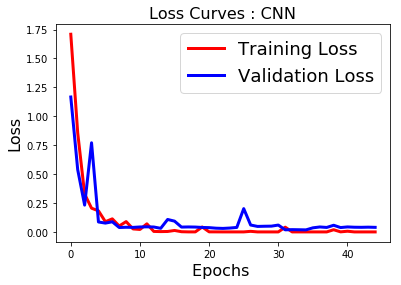

In [21]:
fig=plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves : CNN',fontsize=16)
fig.savefig(model_name+'.png')
plt.show()

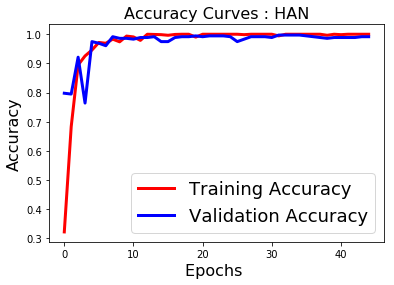

In [22]:
fig=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : HAN',fontsize=16)
fig.savefig(model_name+'-ACC'+'.png')
plt.show()

In [0]:
# Save the trained weights
model.save(model_name + ".h5")

# Save model config as json
model_json = model.to_json()
with open(model_name + ".json", "w") as json_file:
    json_file.write(model_json)

# Persist the model to your google drive [VERY IMPORTANT]
!cp CNN* gdrive/My\ Drive/

## Predict on Test Data

In [0]:
!cp gdrive/My\ Drive/CNN-0.4-300-Trainable-Truefinal_weights.26-0.01.hdf5 .
!cp gdrive/My\ Drive/CNN-0.4-300-Trainable-Truefinal.json .


In [0]:
from keras.models import model_from_json

json_file = open('CNN-0.4-300-Trainable-Truefinal.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
best_model = model_from_json(loaded_model_json)

best_model.load_weights('CNN-0.4-300-Trainable-Truefinal_weights.26-0.01.hdf5')

best_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [0]:
def find_test_acc(prediction):
  count = 0
  t = 0
  for pred in prediction:
    p = pred.argmax()
    name = le.inverse_transform([p])
    if name == y_test.loc[count]:
      t+=1
    count+=1
  print('Test Accuracy:',(t/count)*100,"%")

In [0]:
def predict_test(model):
  #Tokenize test data and apply model prediction
  sequences = tokenizer.texts_to_sequences(test_text)
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

  print('Shape of data tensor:', data.shape)
  print('Shape of label tensor:', labels.shape)
  prediction = model.predict(data)
  find_test_acc(prediction)

In [28]:
predict_test(best_model)

Shape of data tensor: (445, 1000)
Shape of label tensor: (1780, 5)
Test Accuracy: 96.62921348314607 %


## Tensorboard

In [27]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-05-02 22:34:48--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.45.248.161, 52.204.188.97, 52.22.236.254, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.45.248.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14991793 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.30M  40.5MB/s    in 0.4s    

2019-05-02 22:34:49 (40.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14991793/14991793]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [28]:
LOG_DIR = './Graph_CNN'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://c15680b9.ngrok.io


In [0]:
!cp -r Graph* gdrive/My\ Drive/

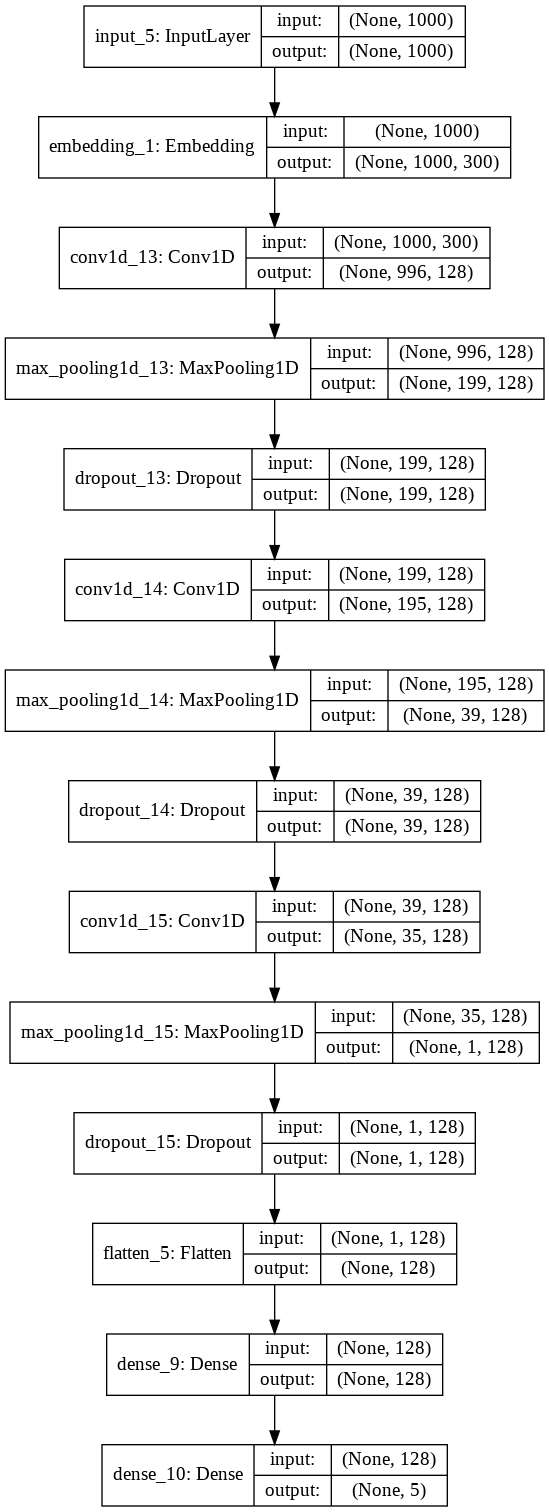

In [48]:
from keras.utils.vis_utils import plot_model
plot_model(best_model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
from PIL import Image
display(Image.open('cnn_model.png'))